# Exploratory Analysis

In [1]:
import random
import torch
from torch.utils.data import Dataset, IterableDataset, DataLoader
import pickle
import numpy as np
import torchvision
from typing import Tuple

In [2]:
def unpickle(f):
    with open(f, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def new_random_crop(labels, new_crop_size):
    crop_map = create_crop_map(len(labels), new_crop_size)
    good_indices = find_good_samples(labels, crop_map, new_crop_size)
    return crop_map, good_indices


def create_crop_map(data_size, crop_size):
    # The crop map assigns an x_shift and y_shift to each sample in the main 64 x 64 dataset.
    crop_map = []
    for i in range(data_size):
        x_shift = random.randint(0, 64 - crop_size)
        y_shift = random.randint(0, 64 - crop_size)
        crop_map.append((x_shift, y_shift))
    return np.array(crop_map)


def get_cropped_sample(index, crop_map, crop_size, data, labels):
    x_shift, y_shift = crop_map[index]
    cropped_features = data[index, :, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size]
    cropped_label = labels[index, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size]
        
    return cropped_features, cropped_label


def find_good_samples(labels, crop_map, crop_size):
    # Finds the indices of samples that have no missing data in their labels.
    # This is determined AFTER generating a crop map and applying the crop to the original 64 x 64 label.
    good_indices = []
    for i in range(len(labels)):
        x_shift, y_shift = crop_map[i]
        if np.all(np.invert(labels[i, x_shift : x_shift + crop_size, y_shift : y_shift + crop_size] == -1)):
            good_indices.append(i)
    return np.array(good_indices)


class WildfireDataset(torch.utils.data.Dataset):
    def __init__(self, data_filename, labels_filename, crop_size=32, features=None):
        self.data, self.labels = unpickle(data_filename), unpickle(labels_filename)
        self.crop_size = crop_size

        random.seed(1)
        self.crop_map, self.good_indices = new_random_crop(self.labels, self.crop_size)

        if features:
            assert isinstance(features, list)
        self.features = sorted(features) if features else None
        
        print(f"data size: {self.data.nbytes}")
        print(f"label size: {self.labels.nbytes}")
        print(f"crop_map size: {self.crop_map.nbytes}")
        print(f"good_indices size: {self.good_indices.nbytes}")
        print(f"total size: {self.data.nbytes + self.labels.nbytes + self.crop_map.nbytes + self.good_indices.nbytes}")
        print("finished initializing WildfireDataset")
        
    def __len__(self):
        return len(self.good_indices)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        index = self.good_indices[index]
        
        cropped_features, cropped_label = get_cropped_sample(index, self.crop_map, self.crop_size, self.data, self.labels)

        # Only keep specific features
        if self.features:
            cropped_features = cropped_features[self.features, :, :]

        sample = (torch.from_numpy(cropped_features), torch.from_numpy(np.expand_dims(cropped_label, axis=0)))

        return sample

In [3]:
# code from: https://github.com/LeeJunHyun/Image_Segmentation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class R2U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1



class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class R2AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

    
class AttU_Net_S(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net_S,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)
        
        d4 = self.Up4(x4)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [4]:
train_dataset = WildfireDataset("../data/next-day-wildfire-spread/train.data", "../data/next-day-wildfire-spread/train.labels")
test_dataset = WildfireDataset("../data/next-day-wildfire-spread/test.data", "../data/next-day-wildfire-spread/test.labels")
validation_dataset = WildfireDataset("../data/next-day-wildfire-spread/validation.data", "../data/next-day-wildfire-spread/validation.labels")

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=100, shuffle=True, num_workers=0)

data size: 2944991232
label size: 245415936
crop_map size: 239664
good_indices size: 98800
total size: 3190745632
finished initializing WildfireDataset
data size: 332070912
label size: 27672576
crop_map size: 27024
good_indices size: 11016
total size: 359781528
finished initializing WildfireDataset
data size: 369033216
label size: 30752768
crop_map size: 30032
good_indices size: 12440
total size: 399828456
finished initializing WildfireDataset


In [4]:
import sys
import numpy
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/3373256/set-colorbar-range-in-matplotlib

def dataset_fire_mask_heat_maps(image_shape, main_title, train_loader, test_loader, validation_loader):
    train_heat_map = np.zeros(image_shape)
    test_heat_map = np.zeros(image_shape)
    validation_heat_map = np.zeros(image_shape)
    side_length = image_shape[0]
    
    n_rows = 1
    n_cols = 3
    
    fig = plt.figure(figsize=(15,4.25))
    
    for i, (batch_inputs, batch_labels) in enumerate(train_loader):
        for fire_mask in batch_labels:
            train_heat_map += torch.reshape(fire_mask, image_shape).numpy()
            
    for i, (batch_inputs, batch_labels) in enumerate(test_loader):
        for fire_mask in batch_labels:
            test_heat_map += torch.reshape(fire_mask, image_shape).numpy()
    
    for i, (batch_inputs, batch_labels) in enumerate(validation_loader):
        for fire_mask in batch_labels:
            validation_heat_map += torch.reshape(fire_mask, image_shape).numpy()
            
    plt.suptitle(main_title)
        
    plt.subplot(n_rows, n_cols, 1)
    plt.title("Train set")
    plt.imshow(train_heat_map, cmap='hot')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")
    
    plt.subplot(n_rows, n_cols, 2)
    plt.title("Test set")
    plt.imshow(test_heat_map, cmap='hot')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")
    
    plt.subplot(n_rows, n_cols, 3)
    plt.title("Validation set")
    plt.imshow(validation_heat_map, cmap='hot')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")

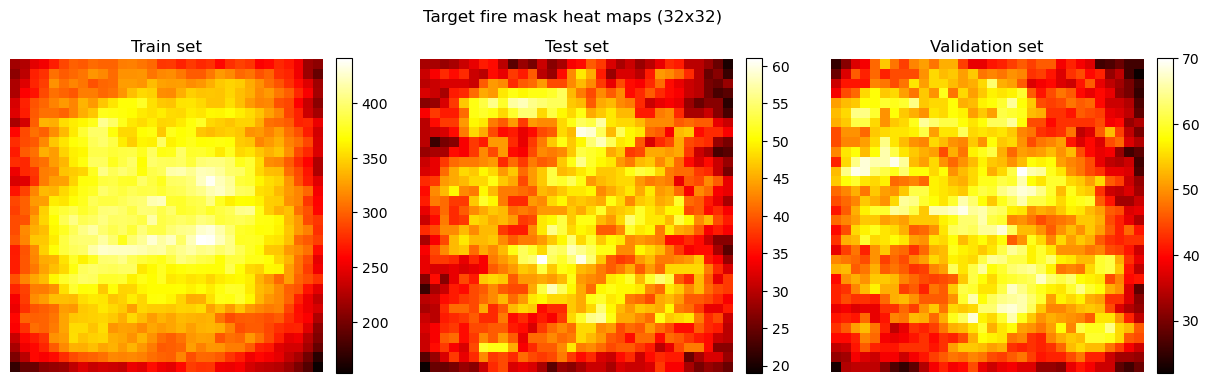

In [6]:
dataset_fire_mask_heat_maps((32, 32), "Target fire mask heat maps (32x32)", train_loader, test_loader, validation_loader)

In [5]:
def load_model(model, path):
    state_dict = torch.load(path, map_location=torch.device('cpu'))
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    return model

def get_model_predictions_heat_map(image_shape, model, loader):
    heat_map = np.zeros(image_shape)
    model.eval()
    with torch.no_grad():
        for i, (batch_inputs, batch_labels) in enumerate(loader):
            out = model(batch_inputs)
            
            threshold = 0.5
            preds = torch.where(torch.sigmoid(out) > threshold, 1, 0)
            
            for prediction in preds:
                heat_map += torch.reshape(prediction, image_shape).numpy()
                
    return heat_map

def plot_heat_map(heat_map, title):
    plt.title(title)
    plt.imshow(heat_map, cmap='hot')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")
    plt.show()
    
def plot_model_heat_maps(heat_maps_list, titles):
    fig = plt.figure(figsize=(15,4))
    
    n_rows = 1
    n_cols = len(heat_maps_list)
    
    plt.suptitle("Prediction heat maps on the test set")
    
    for i, heat_map in enumerate(heat_maps_list):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.title(titles[i])
        plt.imshow(heat_map, cmap='hot')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")

In [8]:
unet_path = "../savedModels/leejunhyun-unet-experiment-32x32-baseline/model-U_Net-bestF1Score-Rank-0.weights"
r2unet_path = "../savedModels/leejunhyun-r2unet-experiment-32x32-baseline/model-R2U_Net-bestF1Score-Rank-0.weights"
attunet_path = "../savedModels/leejunhyun-attunet-experiment-32x32-baseline/model-AttU_Net-bestF1Score-Rank-0.weights"
r2attunet_path = "../savedModels/leejunhyun-r2attunet-experiment-32x32-baseline/model-R2AttU_Net-bestF1Score-Rank-0.weights"
attunet_s_path = "../savedModels/small-attunet-32x32-12-features/model-AttU_Net_S-bestF1Score-Rank-0.weights"

unet_model = load_model(U_Net(12, 1), unet_path)
r2unet_model = load_model(R2U_Net(12, 1), r2unet_path)
attunet_model = load_model(AttU_Net(12, 1), attunet_path)
r2attunet_model = load_model(R2AttU_Net(12, 1), r2attunet_path)
attunet_s_model = load_model(AttU_Net_S(12, 1), attunet_s_path)

unet_heat_map = get_model_predictions_heat_map((32, 32), unet_model, test_loader)
del unet_model
r2unet_heat_map = get_model_predictions_heat_map((32, 32), r2unet_model, test_loader)
del r2unet_model
attunet_heat_map = get_model_predictions_heat_map((32, 32), attunet_model, test_loader)
del attunet_model
r2attunet_heat_map = get_model_predictions_heat_map((32, 32), r2attunet_model, test_loader)
del r2attunet_model
attunet_s_heat_map = get_model_predictions_heat_map((32, 32), attunet_s_model, test_loader)
del attunet_s_model

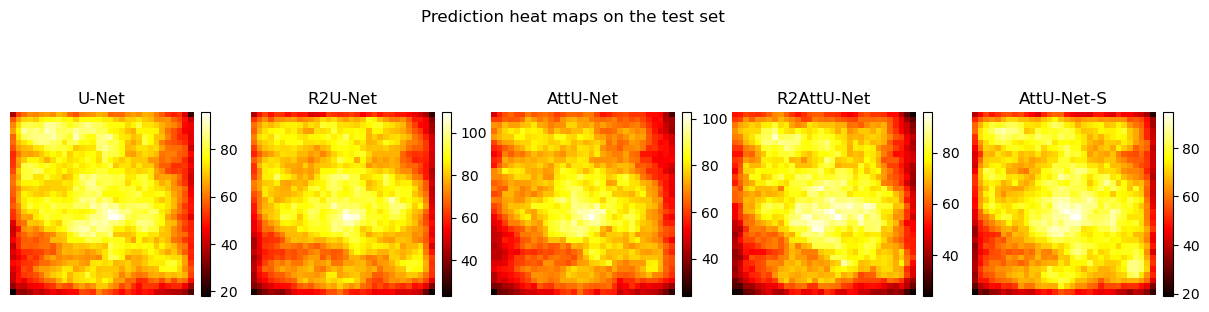

In [9]:
titles = ["U-Net", "R2U-Net", "AttU-Net", "R2AttU-Net", "AttU-Net-S"]
plot_model_heat_maps([unet_heat_map, r2unet_heat_map, attunet_heat_map, r2attunet_heat_map, attunet_s_heat_map], titles)

In [6]:
train_dataset = WildfireDataset(data_filename="../data/next-day-wildfire-spread/train.data", 
                                labels_filename="../data/next-day-wildfire-spread/train.labels", 
                                crop_size=64)

test_dataset = WildfireDataset(data_filename="../data/next-day-wildfire-spread/test.data", 
                               labels_filename="../data/next-day-wildfire-spread/test.labels", 
                               crop_size=64)

validation_dataset = WildfireDataset(data_filename="../data/next-day-wildfire-spread/validation.data", 
                                     labels_filename="../data/next-day-wildfire-spread/validation.labels", 
                                     crop_size=64)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=100, shuffle=True, num_workers=0)

data size: 2944991232
label size: 245415936
crop_map size: 239664
good_indices size: 84048
total size: 3190730880
finished initializing WildfireDataset
data size: 332070912
label size: 27672576
crop_map size: 27024
good_indices size: 8896
total size: 359779408
finished initializing WildfireDataset
data size: 369033216
label size: 30752768
crop_map size: 30032
good_indices size: 10720
total size: 399826736
finished initializing WildfireDataset


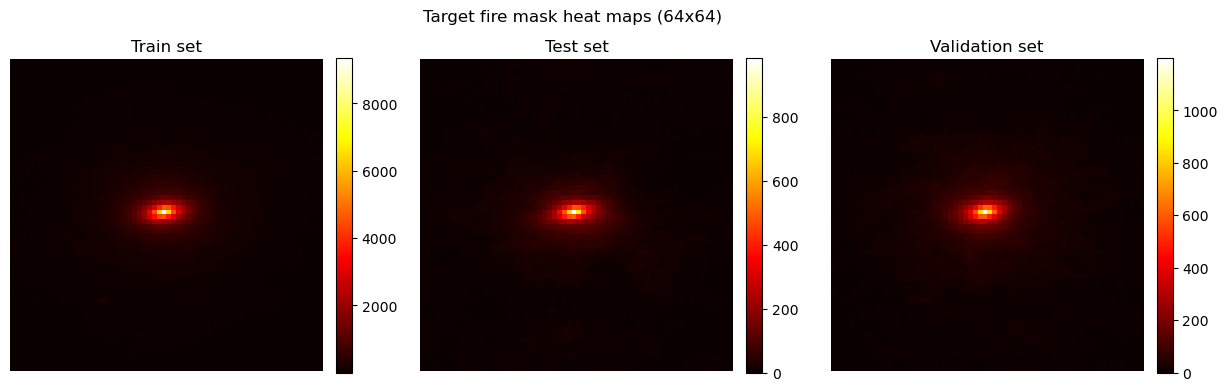

In [7]:
dataset_fire_mask_heat_maps((64, 64), "Target fire mask heat maps (64x64)", train_loader, test_loader, validation_loader)

In [8]:
unet_path = "../savedModels/leejunhyun-unet-experiment-1/model-U_Net-bestF1Score-Rank-0.weights"
r2unet_path = "../savedModels/leejunhyun-unet-experiment-2/model-R2U_Net-bestF1Score-Rank-0.weights"
attunet_path = "../savedModels/leejunhyun-unet-experiment-3/model-AttU_Net-bestF1Score-Rank-0.weights"
r2attunet_path = "../savedModels/leejunhyun-unet-experiment-4/model-R2AttU_Net-bestF1Score-Rank-0.weights"
attunet_s_path = "../savedModels/small-attunet-64x64-experiment/model-AttU_Net_S-bestF1Score-Rank-0.weights"

unet_model = load_model(U_Net(12, 1), unet_path)
r2unet_model = load_model(R2U_Net(12, 1), r2unet_path)
attunet_model = load_model(AttU_Net(12, 1), attunet_path)
r2attunet_model = load_model(R2AttU_Net(12, 1), r2attunet_path)
attunet_s_model = load_model(AttU_Net_S(12, 1), attunet_s_path)

unet_heat_map = get_model_predictions_heat_map((64, 64), unet_model, test_loader)
del unet_model
r2unet_heat_map = get_model_predictions_heat_map((64, 64), r2unet_model, test_loader)
del r2unet_model
attunet_heat_map = get_model_predictions_heat_map((64, 64), attunet_model, test_loader)
del attunet_model
r2attunet_heat_map = get_model_predictions_heat_map((64, 64), r2attunet_model, test_loader)
del r2attunet_model
attunet_s_heat_map = get_model_predictions_heat_map((64, 64), attunet_s_model, test_loader)
del attunet_s_model

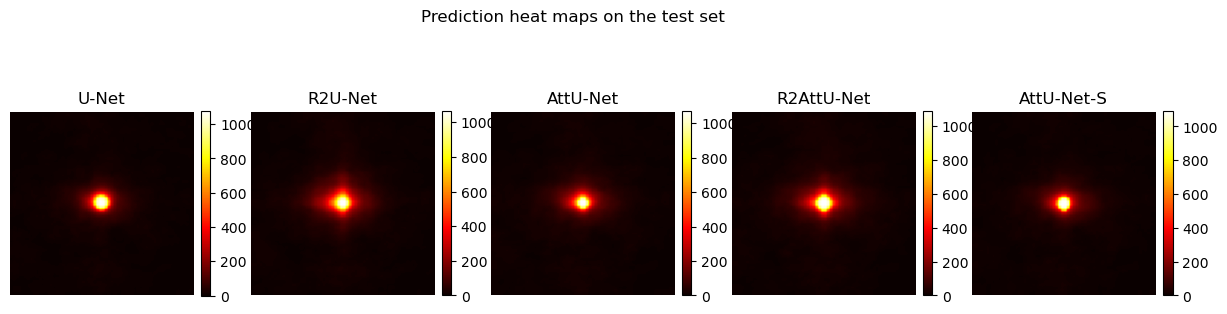

In [9]:
titles = ["U-Net", "R2U-Net", "AttU-Net", "R2AttU-Net", "AttU-Net-S"]
plot_model_heat_maps([unet_heat_map, r2unet_heat_map, attunet_heat_map, r2attunet_heat_map, attunet_s_heat_map], titles)